In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [27]:
ratings.head()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
print("Number of ratings: " + str(len(ratings)))
print("Number of movies: " + str(len(movies)))

Number of ratings: 100836
Number of movies: 9742


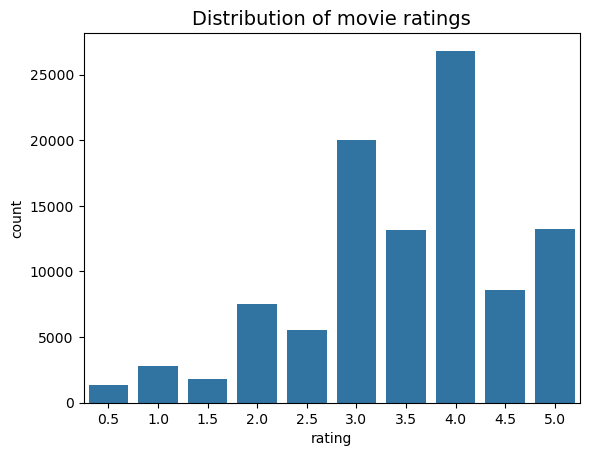

In [9]:
sns.countplot(x = 'rating', data = ratings) #print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")palette = "viridis")
plt.title("Distribution of movie ratings", fontsize = 14)
plt.show()

In [15]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [17]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: 3.66.


In [19]:
ratings['movieId'].value_counts().reset_index()
#movieId has that many ratings

,movieId,count
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
9719,86279,1
9720,86922,1
9721,5962,1
9722,87660,1


In [29]:
movies_ratings = ratings.merge(movies, on = 'movieId')
movies_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [31]:
movies_ratings['title'].value_counts()[0:10]#reset_index()

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

In [33]:
#Which movie has the lowest and highest average rating?
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()  #index minimum
movies_ratings[movies_ratings['movieId'] == lowest_rated]

,userId,movieId,rating,timestamp,title,genres
13633,89,3604,0.5,1520408880,Gypsy (1962),Musical


In [35]:
highest_rated = mean_ratings['rating'].idxmax()
movies_ratings[movies_ratings['movieId'] == highest_rated]

,userId,movieId,rating,timestamp,title,genres
13368,85,53,5.0,889468268,Lamerica (1994),Adventure|Drama
96115,603,53,5.0,963180003,Lamerica (1994),Adventure|Drama


In [37]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index() #count and mean are functions
movie_stats.head()
#movieId 1 rated 215 times and the average rating is 3.92..

,movieId,count,mean
0,1,215,3.920930
1,2,110,3.431818
2,3,52,3.259615
3,4,7,2.357143
4,5,49,3.071429


In [39]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print("Average number of ratings for a given movie: " + str(C))
print(f"Average rating for a given movie: {m:.2f}")

Average number of ratings for a given movie: 10.369806663924312
Average rating for a given movie: 3.26


In [41]:
def bayesian_avg(ratings):                               #input of this function is a pandas series
    b_avg = (C*m + ratings.sum())/(C + ratings.count())
    return round(b_avg,3)

In [43]:
lamerica = pd.Series([5,5])  #the two ratings for "Lamerica" movie
bayesian_avg(lamerica)

3.543

In [45]:
#APPLYING BAYESIAN AVERAGE TO ALL THE MOVIES

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
bayesian_avg_ratings

,movieId,bayesian_avg
0,1,3.891
1,2,3.417
2,3,3.260
3,4,2.898
4,5,3.105
...,...,...
9719,193581,3.327
9720,193583,3.283
9721,193585,3.283
9722,193587,3.283


In [47]:
movie_stats = movie_stats.merge(bayesian_avg_ratings, on = 'movieId')
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [49]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.head()

,movieId,count,mean,bayesian_avg,title
0,1,215,3.920930,3.891,Toy Story (1995)
1,2,110,3.431818,3.417,Jumanji (1995)
2,3,52,3.259615,3.260,Grumpier Old Men (1995)
3,4,7,2.357143,2.898,Waiting to Exhale (1995)
4,5,49,3.071429,3.105,Father of the Bride Part II (1995)


In [51]:
movie_stats.sort_values('bayesian_avg', ascending=False).head()  #highest to lowest rating

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [53]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()   #lowest to highest ratings

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [55]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))  #"genres" becomes a list instead of a string 
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [57]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [59]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


In [61]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index() #transpose
genre_frequency_df.columns = ['Genres', 'Count']

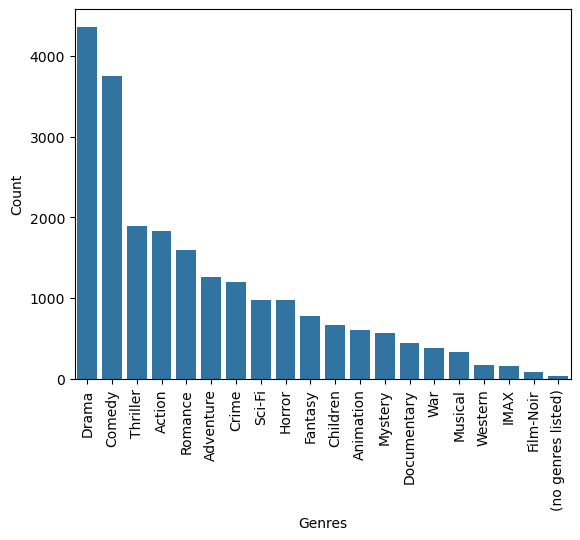

In [63]:
sns.barplot(x = 'Genres', y = 'Count', data = genre_frequency_df.sort_values(by = 'Count', ascending = False))
plt.xticks(rotation = 90)
plt.show()

In [65]:
#DATA PRE-PROCESSING (COLLABORATIVE FILTERING)
#need to transfer data into a utility matrix

from scipy.sparse import csr_matrix

In [67]:
def create_X(df):
     """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    
     M = df['userId'].nunique()
     N = df['movieId'].nunique()

     user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))     #dictionary
     movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

     user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
     movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

     user_index = [user_mapper[i] for i in df['userId']]
     item_index = [movie_mapper[i] for i in df['movieId']]

     X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
     return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [69]:
X.shape  #user item matrix

(610, 9724)

In [71]:
user_mapper

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

In [73]:
#EVALUATING SPARSITY (lower sparsity means using content based filtering would be better)
#sparsity = no. of zero-valued elements/ total no. of elements

n_total = X.shape[0]*X.shape[1] #610 * 9724
n_ratings = X.nnz  #no.of stored non empty elements in a matrix
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")
#above 0.1% is good for collaborative filtering, anything lower indicates using content based filtering 

Matrix sparsity: 1.7%


In [75]:
#finding out active/inactive users

n_ratings_per_user = X.getnnz(axis = 1) #no. of users
len(n_ratings_per_user)

610

In [77]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [79]:
n_ratings_per_movie = X.getnnz(axis = 0) #no. of movies
len(n_ratings_per_movie)

9724

In [81]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


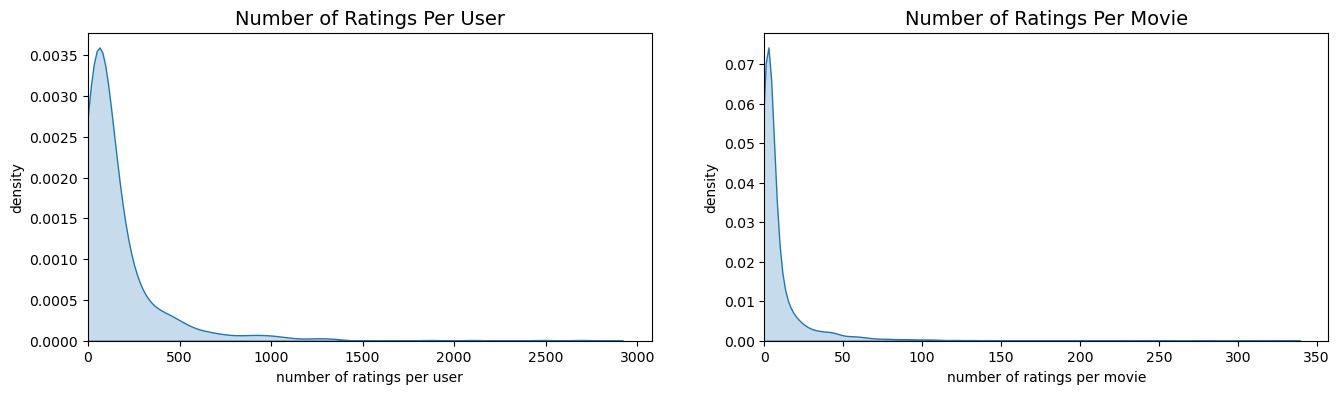

In [83]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill = True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill = True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [ ]:
#k-nearest neighbour (algorithm)

from sklearn.neighbors import NearestNeighbors

In [ ]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):   #k --> determines how many similar movies we want to find
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies  #output movie ids

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}, we recommend:")
for i in similar_movies:
    print(movie_titles[i])

In [ ]:
#trying a different metric

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}, we recommend:")
for i in similar_movies:
    print(movie_titles[i])

In [3]:
#HANDLING THE COLD START PROBLEM
#Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.
#First, we need to convert the "genres" column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1

n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [4]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])
movie_genres.head()

,T,D,W,h,s,u,i,M,-,H,...,o,A,(,F,I,d,N,C,,l
0,0,0,0,1,1,1,1,0,0,0,...,1,1,0,1,0,1,0,1,0,1
1,0,0,0,1,1,1,1,0,0,0,...,0,1,0,1,0,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [5]:
from sklearn.metrics.pairwise import cosine_similarity     #cosine similarity is a tool in sklearn

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [6]:
cosine_sim[0]
#1 means very similar

array([1.        , 0.9459053 , 0.62254302, ..., 0.3441236 , 0.61177529,
       0.56195149])

In [7]:
#this funtion below helps us find close matches (in case we forget the name of the whole movie)

from fuzzywuzzy import process

In [8]:
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [9]:
title = movie_finder('mission possible')
title

'Mission: Impossible (1996)'

In [10]:
#mapping movie_finder to movie_idx

movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 546


In [ ]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores #outputs index and scores

In [12]:
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]  #index 0 indicated the selected movie itself
sim_scores

[(1357, 0.9999999999999993),
 (1505, 0.9999999999999993),
 (1577, 0.9999999999999993),
 (1706, 0.9999999999999993),
 (2355, 0.9999999999999993),
 (2539, 0.9999999999999993),
 (2809, 0.9999999999999993),
 (3000, 0.9999999999999993),
 (3230, 0.9999999999999993),
 (3336, 0.9999999999999993)]

In [13]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[1357, 1505, 1577, 1706, 2355, 2539, 2809, 3000, 3230, 3336]

In [14]:
print(f"Because you watched {title}, we recommend:")
movies['title'].iloc[similar_movies]

Because you watched Toy Story (1995), we recommend:


1357                             Borrowers, The (1997)
1505                        Black Cauldron, The (1985)
1577                     Lord of the Rings, The (1978)
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2539             We're Back! A Dinosaur's Story (1993)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3230                  Atlantis: The Lost Empire (2001)
3336                      Land Before Time, The (1988)
Name: title, dtype: object